In [1]:
!pip install pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 7.9 MB/s eta 0:00:00


In [2]:
import pandas as pd

In [3]:
import json
import pandas as pd
from pandas import json_normalize

# Load the JSON file
with open('/kaggle/input/robflow-pedestrian/train/_annotations.coco.json') as f:
    data = json.load(f)

# Inspect the top-level keys
print(data.keys())

# Convert specific parts of the JSON data to DataFrames
images_df = json_normalize(data, 'images')
annotations_df = json_normalize(data, 'annotations')
categories_df = json_normalize(data, 'categories')

# Display the DataFrames
print("Images DataFrame:")
print(images_df.head())
print("\nAnnotations DataFrame:")
print(annotations_df.head())
print("\nCategories DataFrame:")
print(categories_df.head())

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])
Images DataFrame:
   id  license                                          file_name  height  \
0   0        1  val_all_data--8-_jpg.rf.3b546408821cfa3a71b9b9...     448   
1   1        1  val_all_data--24-_jpg.rf.3c05bf25028d2914da42f...     448   
2   2        1  train_all_data--220-_jpg.rf.3bbdf0ac5b7eac8fc7...     448   
3   3        1  train_all_data--379-_jpg.rf.3c26564a2fc3db97e3...     448   
4   4        1  train_all_data--485-_jpg.rf.3c0085d627bc219292...     448   

   width              date_captured  
0    448  2022-11-03T08:34:58+00:00  
1    448  2022-11-03T08:34:58+00:00  
2    448  2022-11-03T08:34:58+00:00  
3    448  2022-11-03T08:34:58+00:00  
4    448  2022-11-03T08:34:58+00:00  

Annotations DataFrame:
   id  image_id  category_id                bbox   area segmentation  iscrowd
0   0         0            1  [170, 21, 88, 282]  24816           []        0
1   1         1            4  [232, 225,

In [4]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt

# Function to draw bounding boxes on an image
def draw_bounding_boxes(image, annotations):
    for _, row in annotations.iterrows():
        # Extracting bounding box coordinates
        xmin, ymin, width, height = row['bbox']
        xmax = xmin + width
        ymax = ymin + height
        # Drawing the bounding box
        cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 2) # Blue bounding box
    return image

# Function to display images
def display_image(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [5]:
# Path to the folder containing images
image_folder = '/kaggle/input/robflow-pedestrian/train'
for image_id in annotations_df['image_id'].unique():
    image_info = images_df[images_df['id'] == image_id].iloc[0]
    filename = image_info['file_name']
    
    image_path = f'{image_folder}/{filename}'
    image = cv2.imread(image_path)
    
    if image is not None:
        image_annotations = annotations_df[annotations_df['image_id'] == image_id]
        image_with_boxes = draw_bounding_boxes(image, image_annotations)
    else:
        print(f"Image {filename} not found.")
    break

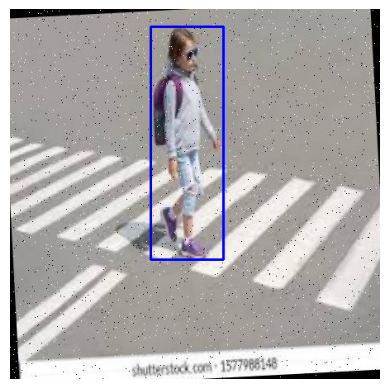

In [6]:
display_image(image_with_boxes)

In [7]:
num_classes = categories_df['name'].nunique()
print(f"Number of classes: {num_classes}")

unique_classes = categories_df['name'].unique()
print(f"Classes: {unique_classes}")


Number of classes: 5
Classes: ['Pedestrians' 'child' 'person' 'silver' 'wheel']


In [8]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms as T
from pycocotools.coco import COCO
from PIL import Image
import os
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

class CocoDataset(torch.utils.data.Dataset):
    def __init__(self, root, annFile, transforms=None):
        self.root = root
        self.coco = COCO(annFile)
        self.ids = list(self.coco.imgToAnns.keys())
        self.transforms = transforms

        # Create a mapping from category IDs to a consecutive range of labels (starting from 1)
        self.cat_id_to_label = {cat['id']: idx + 1 for idx, cat in enumerate(self.coco.loadCats(self.coco.getCatIds()))}

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)
        img = coco.loadImgs(img_id)[0]
        path = img['file_name']

        image = Image.open(os.path.join(self.root, path)).convert('RGB')

        if len(anns) == 0:
            # Skip images with no annotations
            return None

        boxes = []
        labels = []
        for ann in anns:
            xmin = ann['bbox'][0]
            ymin = ann['bbox'][1]
            width = ann['bbox'][2]
            height = ann['bbox'][3]
            xmax = xmin + width
            ymax = ymin + height
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(ann['category_id'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([img_id])

        if self.transforms is not None:
            image = self.transforms(image)

        return image, target

    def __len__(self):
        return len(self.ids)

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    return T.Compose(transforms)

def collate_fn(batch):
    # Filter out None values
    batch = list(filter(lambda x: x is not None, batch))
    return tuple(zip(*batch))

# Paths
train_root = '/kaggle/input/robflow-pedestrian/train'
train_annFile = '/kaggle/input/robflow-pedestrian/train/_annotations.coco.json'

val_root = '/kaggle/input/robflow-pedestrian/valid'
val_annFile = '/kaggle/input/robflow-pedestrian/valid/_annotations.coco.json'

# Create the dataset
train_dataset = CocoDataset(train_root, train_annFile, transforms=get_transform(train=True))
val_dataset = CocoDataset(val_root, val_annFile, transforms=get_transform(train=True))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.20s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [9]:
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

model = get_model(num_classes+1)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 153MB/s]


In [10]:
def convert_to_serializable(obj):
    if isinstance(obj, np.int64):
        return int(obj)
    if isinstance(obj, np.float64):
        return float(obj)
    return obj

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from torchvision.ops import nms

# Function to draw bounding boxes on the image
def draw_boxes(image, boxes, labels, scores=None, label_map=None):
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)
    
    for i, box in enumerate(boxes):
        if labels[i] not in label_map:
            continue  # Skip invalid labels

        xmin, ymin, xmax, ymax = box
        width, height = xmax - xmin, ymax - ymin
        edgecolor = 'r' if scores is None else 'g'
        linewidth = 1 if scores is None else max(1, scores[i] * 5)
        
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=linewidth, edgecolor=edgecolor, facecolor='none')
        ax.add_patch(rect)
        
        if label_map is not None:
            label = label_map.get(labels[i], 'Unknown')
            score = '' if scores is None else f'{scores[i]:.2f}'
            caption = f'{label} {score}'
            ax.text(xmin, ymin, caption, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))
    
    plt.axis('off')
    plt.show()

# Modify the evaluate function to include visualization
def evaluate_and_visualize(model, data_loader, device, label_map, iou_threshold=0.2):
    model.eval()
    coco_results = []
    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc='Validating'):
            images = list(img.to(device) for img in images)
            outputs = model(images)
            for i, output in enumerate(outputs):
                boxes = output['boxes'].cpu()
                scores = output['scores'].cpu()
                labels = output['labels'].cpu()
                img_id = targets[i]['image_id'].item()
                
                # Apply NMS
                keep = nms(boxes, scores, iou_threshold)
                boxes = boxes[keep].numpy()
                scores = scores[keep].numpy()
                labels = labels[keep].numpy()
                
                # Load the image using PIL
                img_info = data_loader.dataset.coco.loadImgs(img_id)[0]
                img_path = os.path.join(data_loader.dataset.root, img_info['file_name'])
                image = Image.open(img_path).convert('RGB')
                image = np.array(image)
                
                # Draw the boxes on the image
                draw_boxes(image, boxes, labels, scores, label_map)
                
                for box, score, label in zip(boxes, scores, labels):
                    if label not in label_map:
                        continue  # Skip invalid labels
                    coco_results.append({
                        "image_id": int(img_id),  # Convert to native int
                        "category_id": int(label),  # Convert to native int
                        "bbox": [float(box[0]), float(box[1]), float(box[2] - box[0]), float(box[3] - box[1])],
                        "score": float(score)  # Convert to native float
                    })
    return coco_results


# Create a mapping from label index to category name
label_map = {cat['id']: cat['name'] for cat in train_dataset.coco.loadCats(train_dataset.coco.getCatIds())}

In [13]:
import torch.optim as optim
from tqdm import tqdm
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# Training parameters
num_epochs = 10
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Move the model to the right device
model.to(device)

# Construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.1, momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
# Gradient clipping function
def clip_gradients(model, max_norm=2.0):
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

# Function to evaluate the model on the validation set
def evaluate(model, data_loader, device, label_map, iou_threshold=0.5):
    model.eval()
    coco_results = []
    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc='Validating'):
            images = list(img.to(device) for img in images)
            outputs = model(images)
            for i, output in enumerate(outputs):
                boxes = output['boxes']
                scores = output['scores']
                labels = output['labels']
                img_id = targets[i]['image_id'].item()
                
                # Apply NMS
                keep = nms(boxes, scores, iou_threshold)
                boxes = boxes[keep].cpu().numpy()
                scores = scores[keep].cpu().numpy()
                labels = labels[keep].cpu().numpy()
                
                for box, score, label in zip(boxes, scores, labels):
                    if label not in label_map:
                        continue  # Skip invalid labels
                    coco_results.append({
                        "image_id": int(img_id),  # Convert to native int
                        "category_id": int(label),  # Convert to native int
                        "bbox": [float(box[0]), float(box[1]), float(box[2] - box[0]), float(box[3] - box[1])],
                        "score": float(score)  # Convert to native float
                    })
    return coco_results

# Create a mapping from label index to category name
label_map = {cat['id']: cat['name'] for cat in train_dataset.coco.loadCats(train_dataset.coco.getCatIds())}

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0  # Accumulate the loss
    for images, targets in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        # Check for NaN values in the losses
        if torch.isnan(losses):
            print("NaN loss encountered. Skipping this batch.")
            continue

        # Backward pass and optimization step
        optimizer.zero_grad()
        losses.backward()
        
        # Clip gradients to avoid exploding gradients
        clip_gradients(model)
        
        optimizer.step()
#         print(losses)

        running_loss += losses.item()  # Accumulate the loss

    # Calculate the average loss over the epoch
    avg_loss = running_loss / len(train_loader)

    # Update the learning rate
    lr_scheduler.step()

    print(f"Epoch {epoch+1}, Average Loss: {avg_loss}")

    # Perform evaluation and save results to a file
    coco_results = evaluate(model, val_loader, device, label_map)
    
    # Save predictions to a file
    with open(f'predictions_epoch_{epoch+1}.json', 'w') as f:
        json.dump(coco_results, f, indent=4, default=convert_to_serializable)
    
    # Load predictions
    coco_gt = COCO(val_annFile)  # Load the ground truth again
    coco_dt = coco_gt.loadRes(f'predictions_epoch_{epoch+1}.json')

    # Initialize COCOeval object
    coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')

    # Evaluate
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

Epoch 1/10: 100%|██████████| 507/507 [06:53<00:00,  1.23it/s]


Epoch 1, Average Loss: 0.4019838523641376


Validating: 100%|██████████| 50/50 [00:20<00:00,  2.48it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.26s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.86s).
Accumulating evaluation results...
DONE (t=0.26s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.153
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.332
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.108
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.066
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.182
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.121
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.231
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Epoch 2/10: 100%|██████████| 507/507 [06:53<00:00,  1.23it/s]


Epoch 2, Average Loss: 0.32867099834088037


Validating: 100%|██████████| 50/50 [00:20<00:00,  2.47it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.32s).
Accumulating evaluation results...
DONE (t=0.20s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.201
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.407
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.159
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.154
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.090
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.235
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.165
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.266
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Epoch 3/10: 100%|██████████| 507/507 [06:53<00:00,  1.23it/s]


Epoch 3, Average Loss: 0.314831505645309


Validating: 100%|██████████| 50/50 [00:20<00:00,  2.47it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.25s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.33s).
Accumulating evaluation results...
DONE (t=0.23s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.248
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.513
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.184
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.160
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.173
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.270
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.191
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.339
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Epoch 4/10: 100%|██████████| 507/507 [06:53<00:00,  1.23it/s]


Epoch 4, Average Loss: 0.2389873608623501


Validating: 100%|██████████| 50/50 [00:20<00:00,  2.47it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.78s).
Accumulating evaluation results...
DONE (t=0.15s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.397
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.680
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.406
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.238
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.308
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.419
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.282
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.480
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Epoch 5/10: 100%|██████████| 507/507 [06:53<00:00,  1.23it/s]


Epoch 5, Average Loss: 0.20860112911821352


Validating: 100%|██████████| 50/50 [00:20<00:00,  2.48it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.68s).
Accumulating evaluation results...
DONE (t=0.15s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.433
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.739
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.442
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.243
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.360
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.458
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.310
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.521
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Epoch 6/10: 100%|██████████| 507/507 [06:53<00:00,  1.23it/s]


Epoch 6, Average Loss: 0.19374611801091265


Validating: 100%|██████████| 50/50 [00:20<00:00,  2.48it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.71s).
Accumulating evaluation results...
DONE (t=0.14s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.413
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.752
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.420
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.211
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.340
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.438
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.291
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.496
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Epoch 7/10: 100%|██████████| 507/507 [06:53<00:00,  1.23it/s]


Epoch 7, Average Loss: 0.17451886228732102


Validating: 100%|██████████| 50/50 [00:20<00:00,  2.47it/s]


loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.65s).
Accumulating evaluation results...
DONE (t=0.13s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.435
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.752
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.431
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.257
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.388
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.454
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.304
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.520
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Epoch 8/10: 100%|██████████| 507/507 [06:53<00:00,  1.22it/s]


Epoch 8, Average Loss: 0.17087674428960511


Validating: 100%|██████████| 50/50 [00:20<00:00,  2.47it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.69s).
Accumulating evaluation results...
DONE (t=0.14s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.439
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.759
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.440
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.258
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.390
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.462
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.310
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.527
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Epoch 9/10: 100%|██████████| 507/507 [06:54<00:00,  1.22it/s]


Epoch 9, Average Loss: 0.1689126612710412


Validating: 100%|██████████| 50/50 [00:20<00:00,  2.47it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.64s).
Accumulating evaluation results...
DONE (t=0.13s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.440
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.761
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.435
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.263
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.392
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.458
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.308
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.526
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Epoch 10/10: 100%|██████████| 507/507 [06:54<00:00,  1.22it/s]


Epoch 10, Average Loss: 0.1663784696123539


Validating: 100%|██████████| 50/50 [00:20<00:00,  2.47it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.83s).
Accumulating evaluation results...
DONE (t=0.13s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.447
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.763
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.457
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.263
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.395
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.468
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.315
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.536
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random

# Function to draw bounding boxes on the image
def draw_boxes(image, boxes, labels, scores=None, label_map=None):
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)
    
    for i, box in enumerate(boxes):
        if labels[i] not in label_map:
            continue  # Skip invalid labels

        xmin, ymin, xmax, ymax = box
        width, height = xmax - xmin, ymax - ymin
        edgecolor = 'r' if scores is None else 'g'
        linewidth = 1 if scores is None else max(1, scores[i] * 5)
        
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=linewidth, edgecolor=edgecolor, facecolor='none')
        ax.add_patch(rect)
        
        if label_map is not None:
            label = label_map.get(labels[i], 'Unknown')
            score = '' if scores is None else f'{scores[i]:.2f}'
            caption = f'{label} {score}'
            ax.text(xmin, ymin, caption, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))
    
    plt.axis('off')
    plt.show()

# Function to visualize a random subset of images with bounding boxes
def visualize_random_results(result_file, data_loader, label_map, num_images):
    with open(result_file, 'r') as f:
        results = json.load(f)
    
    # Group results by image_id
    from collections import defaultdict
    grouped_results = defaultdict(list)
    for res in results:
        grouped_results[res['image_id']].append(res)
    
    # Select a random subset of image_ids
    image_ids = list(grouped_results.keys())
    random_image_ids = random.sample(image_ids, min(num_images, len(image_ids)))
    
    for img_id in random_image_ids:
        annotations = grouped_results[img_id]
        img_info = data_loader.dataset.coco.loadImgs(img_id)[0]
        img_path = os.path.join(data_loader.dataset.root, img_info['file_name'])
        image = Image.open(img_path).convert('RGB')
        image = np.array(image)
        
        boxes = [ann['bbox'] for ann in annotations]
        scores = [ann['score'] for ann in annotations]
        labels = [ann['category_id'] for ann in annotations]
        
        boxes = np.array(boxes)
        boxes[:, 2] += boxes[:, 0]
        boxes[:, 3] += boxes[:, 1]
        
        draw_boxes(image, boxes, labels, scores, label_map)

In [15]:
coco_results = evaluate(model, val_loader, device, label_map)
with open('coco_results.json', 'w') as f:
    json.dump(coco_results, f, indent=4, default=convert_to_serializable)

Validating: 100%|██████████| 50/50 [00:20<00:00,  2.47it/s]


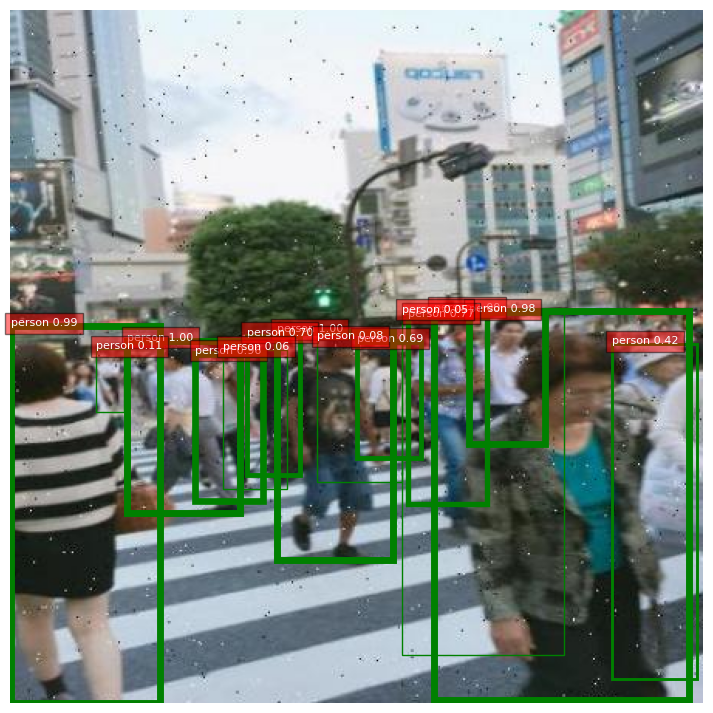

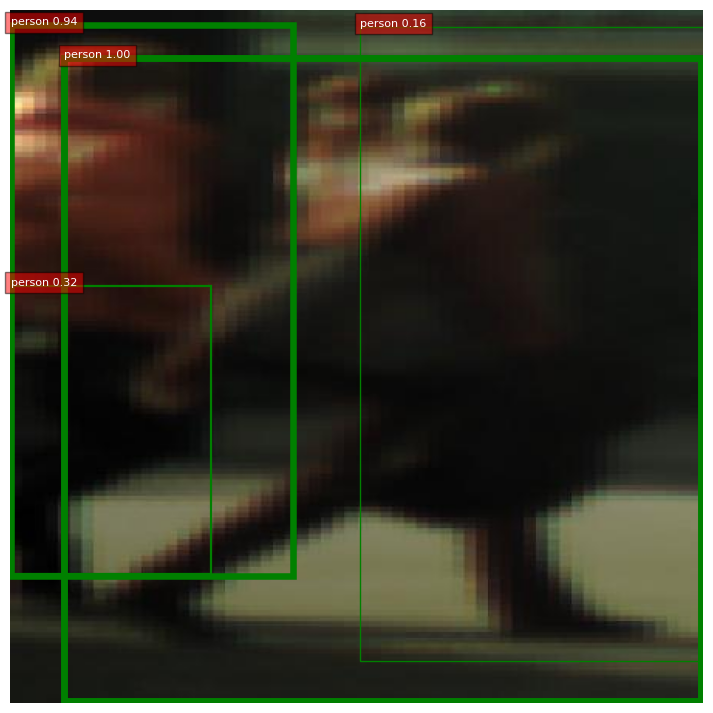

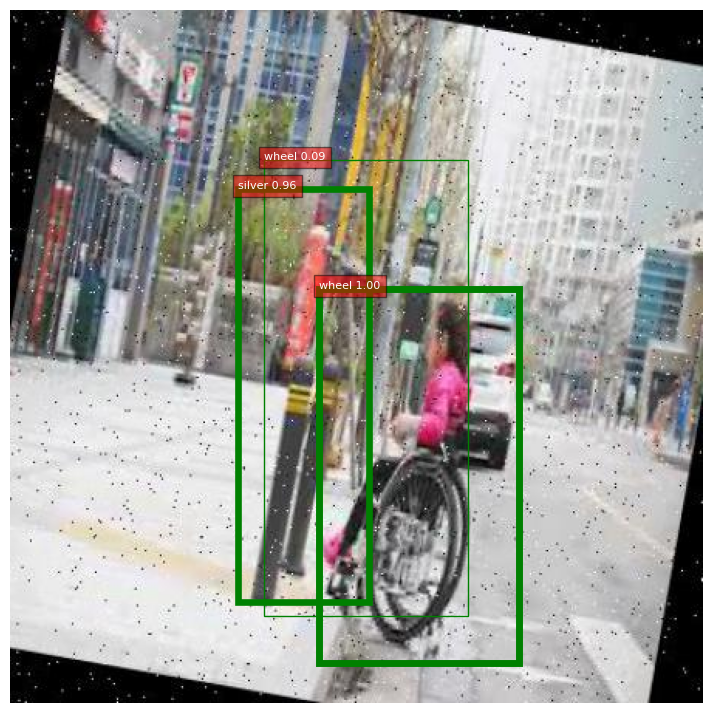

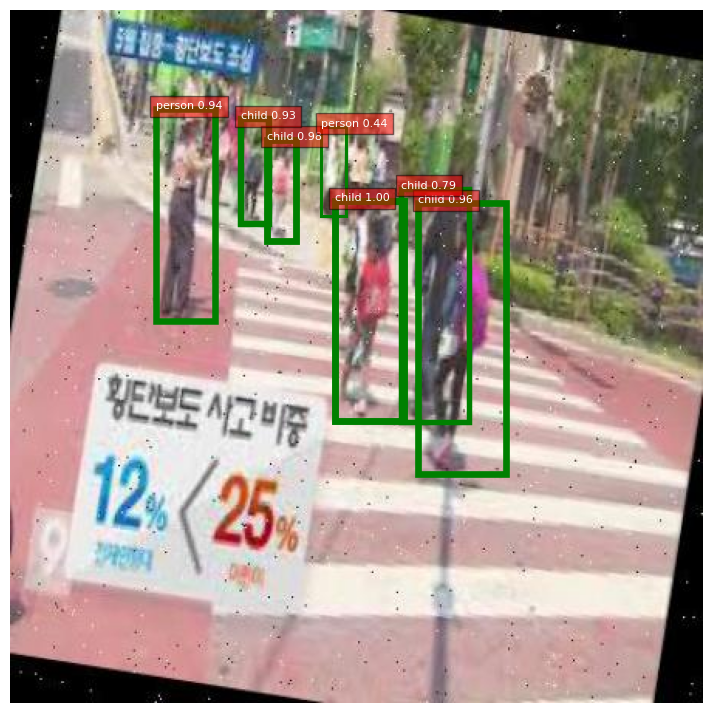

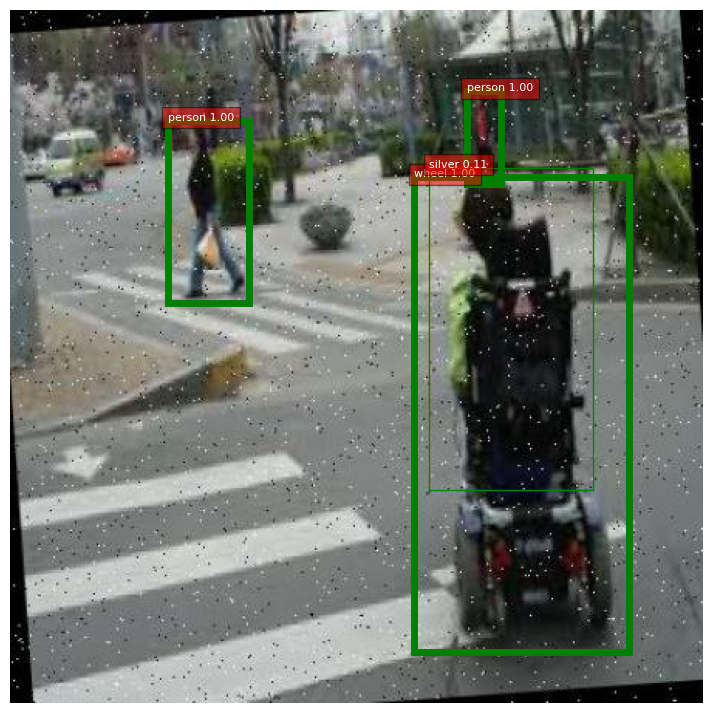

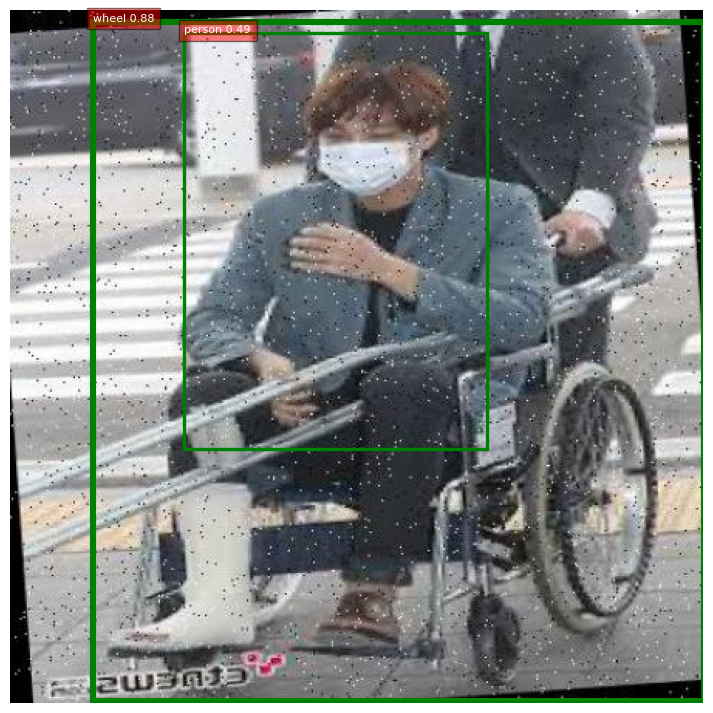

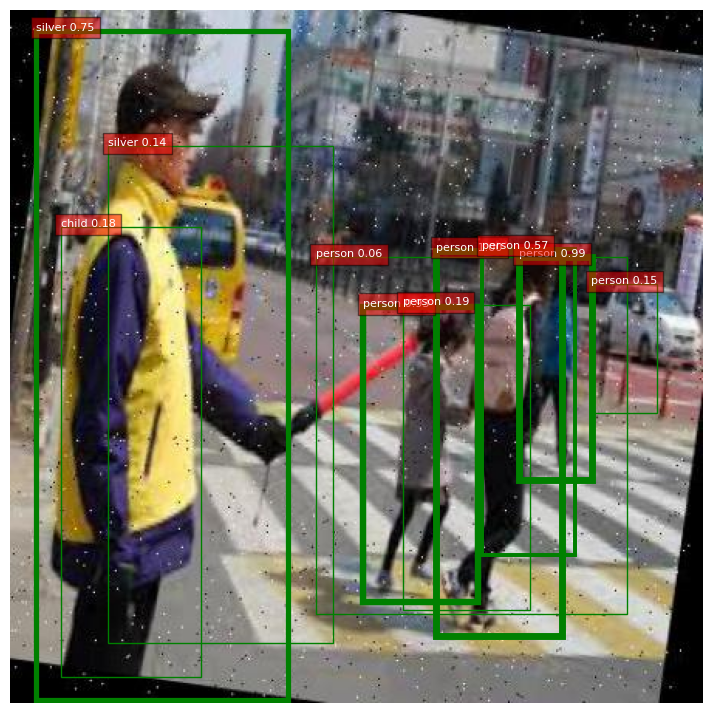

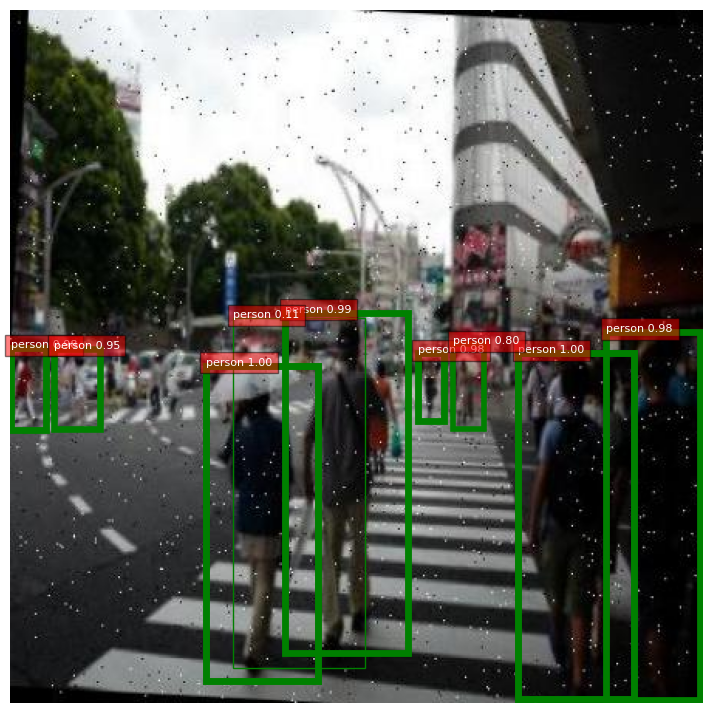

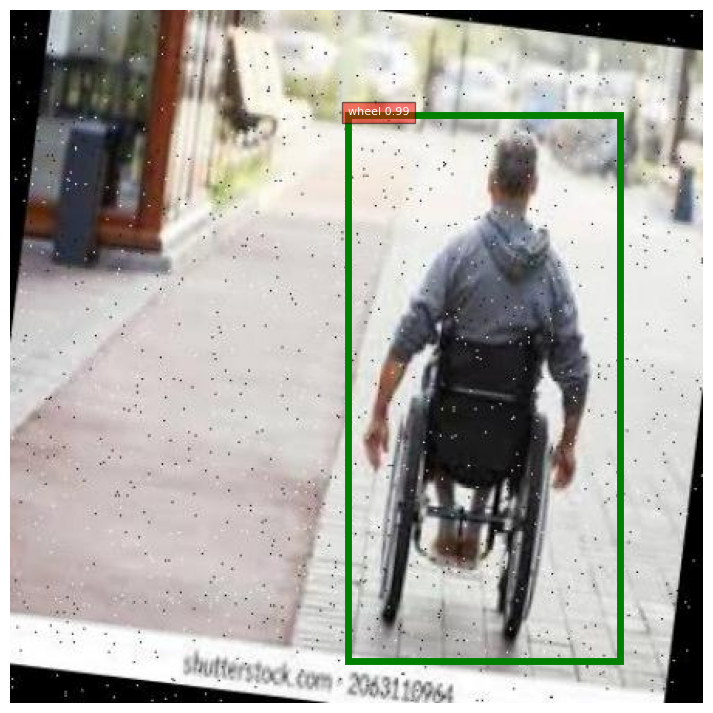

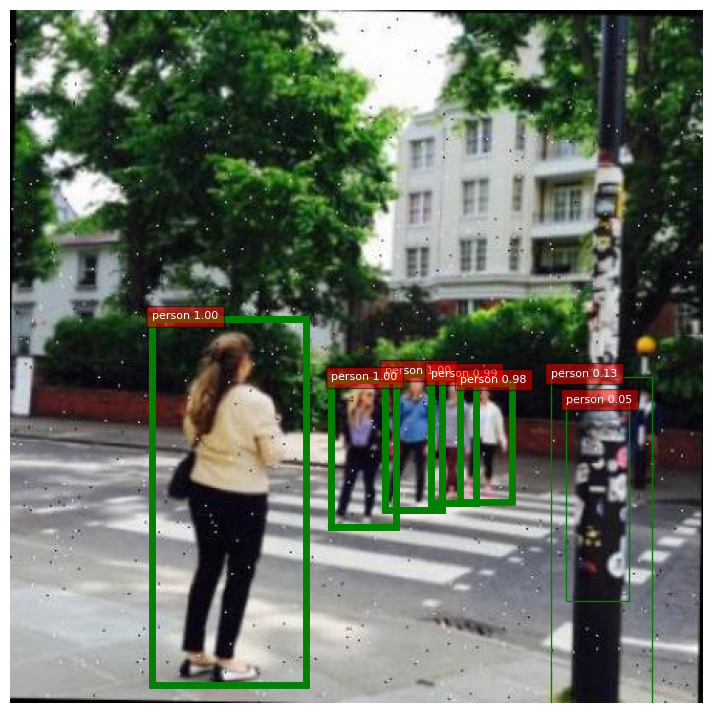

In [16]:
num_images_to_display = 10  # Specify the number of images you want to display
visualize_random_results('coco_results.json', val_loader, label_map, num_images_to_display)

In [17]:
model_save_path = "faster_rcnn_resnet50.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Training completed and model saved at {model_save_path}")

Training completed and model saved at faster_rcnn_resnet50.pth


In [18]:
import os
print("Current Directory:", os.getcwd())
!ls -lh

Current Directory: /kaggle/working
total 179M
---------- 1 root root 9.1M Jun 15 06:22 __notebook__.ipynb
-rw-r--r-- 1 root root 575K Jun 15 06:22 coco_results.json
-rw-r--r-- 1 root root 159M Jun 15 06:22 faster_rcnn_resnet50.pth
-rw-r--r-- 1 root root 3.1M Jun 15 05:16 predictions_epoch_1.json
-rw-r--r-- 1 root root 575K Jun 15 06:22 predictions_epoch_10.json
-rw-r--r-- 1 root root 1.7M Jun 15 05:24 predictions_epoch_2.json
-rw-r--r-- 1 root root 2.0M Jun 15 05:31 predictions_epoch_3.json
-rw-r--r-- 1 root root 796K Jun 15 05:38 predictions_epoch_4.json
-rw-r--r-- 1 root root 655K Jun 15 05:45 predictions_epoch_5.json
-rw-r--r-- 1 root root 662K Jun 15 05:53 predictions_epoch_6.json
-rw-r--r-- 1 root root 606K Jun 15 06:00 predictions_epoch_7.json
-rw-r--r-- 1 root root 591K Jun 15 06:07 predictions_epoch_8.json
-rw-r--r-- 1 root root 564K Jun 15 06:14 predictions_epoch_9.json


In [19]:
!mv faster_rcnn_resnet50.pth /kaggle/working/

mv: 'faster_rcnn_resnet50.pth' and '/kaggle/working/faster_rcnn_resnet50.pth' are the same file
